<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/FastAIDRGrading_ensemble_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install fastai==1.0.42

In [3]:
import os
 
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import cv2
 
from sklearn.model_selection import train_test_split
 
from PIL import Image
 
pd.set_option('display.max_colwidth',1000) # to avoid output truncation

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [6]:
# Set seed for all
# def seed_everything(seed=1358):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

# seed_everything()

#Train Data Read

In [7]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"
 
df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['path'] = dataset_images_location + '/' + df['Image name'] + ".jpg"
df_['level'] = df['Retinopathy grade']
df = df_
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
#df['level'] = df['level'].astype('int32')
# df.head(10)
print(df)
 
img = cv2.imread(df['path'][1])
print(img.dtype)

                                                                                                  path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_303.jpg      2
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_217.jpg      0
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_319.jpg      2
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_115.jpg      3
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_108.jpg      3
..                                                                                                 ...    ...
408  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_116.jpg      2
409  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_156.jpg      0
410  /cont

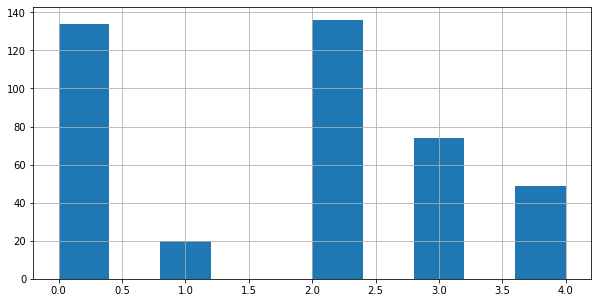

In [8]:
df['level'].hist(figsize = (10, 5))

In [9]:
df.pivot_table(index='level', aggfunc=len)

,path
level,
0,134
1,20
2,136
3,74
4,49


In [10]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

In [11]:
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

83

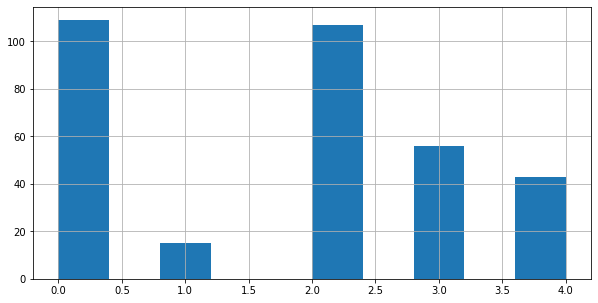

In [12]:
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [13]:
train_df.pivot_table(index='level', aggfunc=len)

,path
level,
0,109
1,15
2,107
3,56
4,43


New Data Size: 545 Old Size: 330


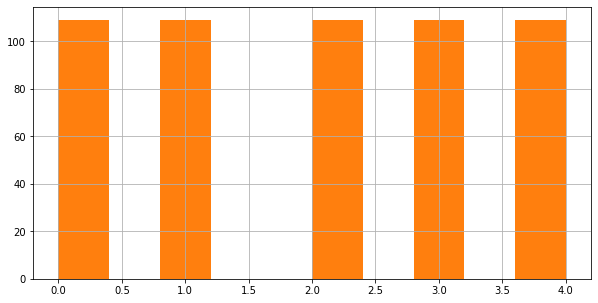

In [14]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [15]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)
print(df)

                                                                                                  path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_065.jpg      3
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_302.jpg      1
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_331.jpg      0
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_075.jpg      3
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_084.jpg      2
..                                                                                                 ...    ...
42   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_282.jpg      2
272  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_171.jpg      0
100  /cont

In [16]:
im = Image.open(train_df['path'][1])
width, height = im.size
# im.show
# print(width,height)

In [17]:
bs = 16 #smaller batch size is better for training, but may take longer
sz=224
print(len(train_df))
print(len(val_df))
print(len(df))

545
83
628


In [18]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [19]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
 
data = ImageDataBunch.from_df(path = '/', df = df, ds_tfms = tfms, size = sz, valid_pct = (len(val_df) / len(df)), bs = bs)
data = data.normalize(imagenet_stats)
print(data)

ImageDataBunch;

Train: LabelList (545 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
3,1,3,2,4
Path: /;

Valid: LabelList (83 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,0,1,2,1
Path: /;

Test: None


[0, 1, 2, 3, 4]


(5, 5)

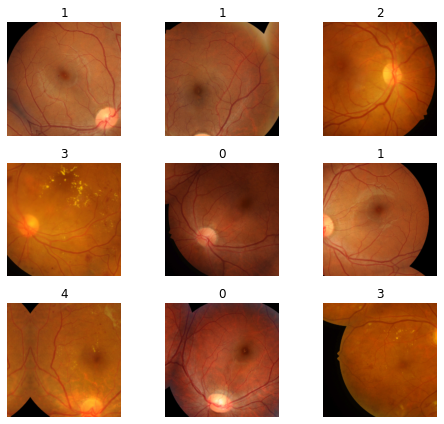

In [20]:
data.show_batch(rows=3, figsize=(7,6))

print(data.classes)
len(data.classes),data.c

#Transfer Learning (Resnet50)

In [21]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat.cpu(),1), y.cpu(), weights='quadratic'),device='cuda:0')

In [ ]:
import torchvision
learn_resnet = create_cnn(data, models.resnet50, metrics = [accuracy,quadratic_kappa])
# learn_densenet = create_cnn(data, models.densenet121, metrics = [accuracy,quadratic_kappa])
# learn = Learner(data, models.EfficientNetB1, metrics = [accuracy,quadratic_kappa])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
# learn_resnet.lr_find()

In [ ]:
# learn_resnet.recorder.plot(suggestion=True)

In [ ]:
# learn_densenet.lr_find()

In [ ]:
# learn_densenet.recorder.plot(suggestion=True)

In [ ]:
learn_resnet.fit_one_cycle(4,max_lr = 1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,2.119775,1.144680,0.674699,0.763947,03:17
1,1.805186,0.968540,0.710843,0.824872,02:53
2,1.565627,0.739216,0.795181,0.871002,02:58
3,1.295715,0.755488,0.783133,0.860763,02:53


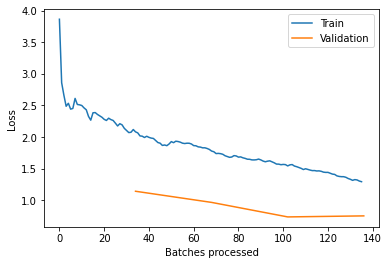

In [ ]:
learn_resnet.recorder.plot_losses()

In [ ]:
learn_resnet.unfreeze()

In [ ]:
# learn_resnet.lr_find()

In [ ]:
# learn_resnet.recorder.plot()

In [ ]:
learn_resnet.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.082080,0.739931,0.783133,0.862202,02:47
1,1.046507,0.710050,0.795181,0.868758,02:51
2,0.993712,0.715854,0.783133,0.869177,02:53
3,0.958246,0.678092,0.795181,0.865057,02:52


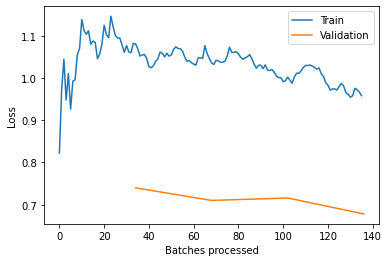

In [ ]:
learn_resnet.recorder.plot_losses()

In [ ]:
# learn_densenet.fit_one_cycle(4,max_lr = 1e-3)

In [ ]:
# learn_densenet.unfreeze()

In [ ]:
# learn_densenet.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

#Progressive Resizing

In [ ]:
dataNew = ImageDataBunch.from_df(path = '/', df = df, ds_tfms = tfms, size = sz * 2, valid_pct = (len(val_df) / len(df)), bs = 4)
dataNew = dataNew.normalize(imagenet_stats)

In [ ]:
learn_resnet.data = dataNew
# learn_densenet.data = dataNew
# learn_efficient.data = dataNew
dataNew.train_ds[0][0].shape

torch.Size([3, 448, 448])

In [ ]:
learn_resnet.freeze()
# learn_densenet.freeze()
# learn_efficient.freeze()

In [ ]:
# learn_resnet.lr_find()
# learn_resnet.recorder.plot()

In [ ]:
learn_resnet.fit_one_cycle(4,max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.763920,1.057703,0.662651,0.579495,03:18
1,1.586880,1.191706,0.530120,0.685174,03:17
2,1.462062,1.072921,0.614458,0.708561,03:19
3,1.320448,0.939125,0.614458,0.635303,03:15


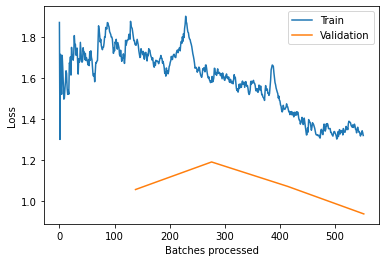

In [ ]:
learn_resnet.recorder.plot_losses()

In [ ]:
learn_resnet.unfreeze()

In [ ]:
# learn_resnet.lr_find()
# learn_resnet.recorder.plot()

In [ ]:
learn_resnet.fit_one_cycle(4,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.312849,0.884287,0.638554,0.713648,03:20
1,1.339187,0.865710,0.626506,0.626046,03:19
2,1.449593,1.015928,0.626506,0.628115,03:20
3,1.351755,0.872537,0.638554,0.641427,03:24


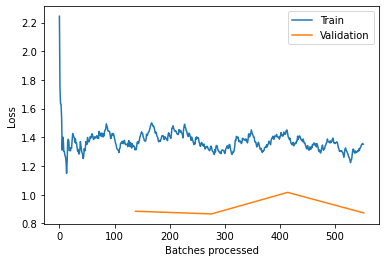

In [ ]:
learn_resnet.recorder.plot_losses()

In [ ]:
# learn_densenet.fit_one_cycle(4,max_lr=1e-3)

In [ ]:
# learn_densenet.unfreeze()

In [ ]:
# learn_densenet.fit_one_cycle(4,max_lr=slice(1e-6,1e-4))

In [ ]:
# learn_efficient.fit_one_cycle(4,max_lr=1e-3)

In [ ]:
# learn_efficient.unfreeze()

In [ ]:
# learn_efficient.fit_one_cycle(4,max_lr=slice(1e-6,1e-4))

In [ ]:
learn_resnet.export('/content/drive/MyDrive/IDRid/Models/ResNet.pkl')

#Checking Results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_resnet)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

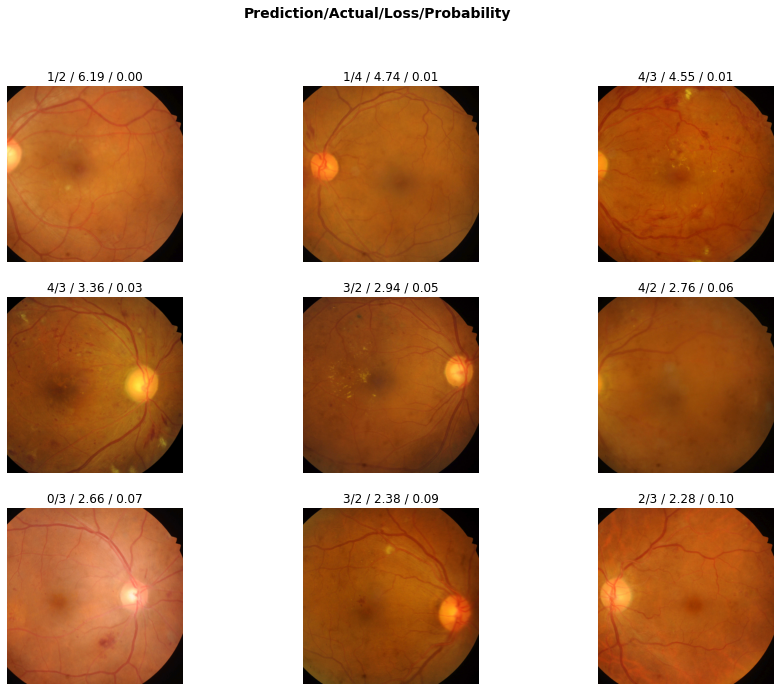

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

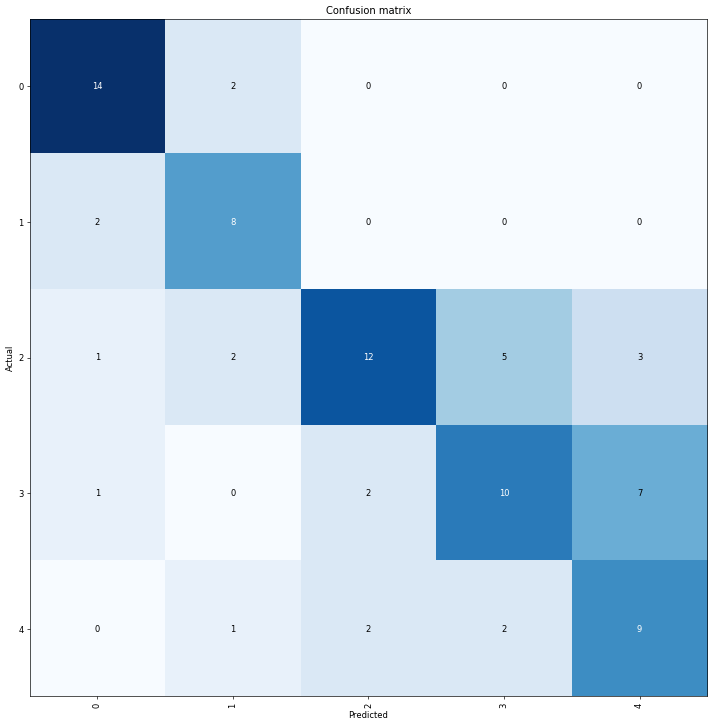

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Testing Data

In [22]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['path'] = test_images_location + '/' + test_df['Image name'] + ".jpg"
test_df_['level'] = test_df['Retinopathy grade']
test_df = test_df_

print(test_df)

                                                                                                 path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_001.jpg      4
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_002.jpg      4
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_003.jpg      4
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_004.jpg      4
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_005.jpg      4
..                                                                                                ...    ...
98   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_099.jpg      0
99   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_100.jpg      2
100  /content/drive

In [27]:
dataset_images_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed 512_Size Images"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed 512_Size Images/file1.csv"
 
df_preprocessed = pd.read_csv(dataset_groundtruth_location)
df_preprocessed_ = pd.DataFrame();
df_preprocessed.columns=('ind','Image name','Retinopathy grade')
df_preprocessed['ind'] = df_preprocessed['ind'].astype(str)
df_preprocessed_['path'] = dataset_images_location + '/' + (df_preprocessed['ind']) + ".jpg"
df_preprocessed_['level'] = df_preprocessed['Retinopathy grade']
df_preprocessed = df_preprocessed_

test_df_preprocessed = df_preprocessed[-103:]
df_preprocessed = df_preprocessed[0:-103]

print(test_df_preprocessed)


                                                                                       path  level
413  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed 512_Size Images/413.jpg      4
414  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed 512_Size Images/414.jpg      4
415  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed 512_Size Images/415.jpg      4
416  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed 512_Size Images/416.jpg      4
417  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed 512_Size Images/417.jpg      4
..                                                                                      ...    ...
511  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed 512_Size Images/511.jpg      0
512  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed 512_Size Images/512.jpg      2
513  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed 512_Size Images/513.jpg      1
514  /cont

In [28]:
# Create a test set to pass to our learner
test = (ImageList.from_df(path='/', df=test_df))
test_preprocessed = (ImageList.from_df(path='/', df=test_df_preprocessed))
# learn_resnet.data.add_test(test)
# learn_densenet.data.add_test(test)
# learn_efficient.data.add_test(test)

In [ ]:
# Get predictions
preds1, l1 = learn_resnet.get_preds(DatasetType.Test)
# preds2, l2 = learn_resnet.TTA(ds_type=DatasetType.Test)

# preds_densenet, l3 = learn_densenet.get_preds(DatasetType.Test)
# preds_efficient, l4 = learn_efficient.get_preds(DatasetType.Test)

In [ ]:
# preds2_densenet, l2_d = learn_densenet.TTA(ds_type=DatasetType.Test)

In [ ]:
# preds1

In [ ]:
# preds2

In [ ]:
# preds_densenet

In [ ]:
preds1 = np.array(preds1)
# preds2 = np.array(preds2)
# preds_densenet = np.array(preds_densenet)
# preds_efficient = np.array(preds_efficient)
# preds_ensenmble = preds1 + preds_densenet
print("preds1", preds1.shape)
# print("preds2", preds2.shape)

preds1 (103, 5)


In [ ]:
preds1 = np.argmax(preds1, axis = 1)
# preds2 = np.argmax(preds2, axis = 1)
# preds_densenet = np.argmax(preds_densenet, axis = 1)
# preds_efficient = np.argmax(preds_efficient, axis = 1)
# preds_ensenmble = np.argmax(preds_ensenmble, axis = 1)
print("preds1", preds1.shape)
# print("preds2", preds2.shape)

preds1 (103,)


In [ ]:
labels = test_df['level']
labels.shape

(103,)

In [ ]:
preds1

array([4, 2, 2, 4, ..., 2, 2, 2, 0])

In [ ]:
# preds2

In [ ]:
from sklearn.metrics import accuracy_score
print("preds1 => accuracy:", accuracy_score(labels, preds1))
# print("preds2(with TTA) => accuracy:", accuracy_score(labels, preds2))
# print("preds_densenet => accuracy:", accuracy_score(labels, preds_densenet))
# print("preds_efficient => accuracy:", accuracy_score(labels, preds_efficient))
# print("preds_ensemble => accuracy:", accuracy_score(labels, preds_ensenmble))

preds1 => accuracy: 0.5145631067961165


In [ ]:
from sklearn.metrics import cohen_kappa_score
print("preds1 => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds1, weights = "quadratic"));
# print("preds2(with TTA) => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds2, weights = "quadratic"));
# print("preds_densenet => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds_densenet, weights = "quadratic"));
# print("preds_efficient => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds_efficient, weights = "quadratic"));
# print("preds_ensemble => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds_ensenmble, weights = "quadratic"));

preds1 => quadratic_weighted_kappa: 0.6809734513274337


In [ ]:
# print("preds_densenet(with TTA) => quadratic_weighted_kappa:", cohen_kappa_score(labels, np.argmax(preds2_densenet, axis = 1), weights = "quadratic"));
# print("preds_densenet(with TTA) => accuracy:", accuracy_score(labels, np.argmax(preds2_densenet, axis = 1)));

preds1 => Confusion Matrix
[[21  7  6  0  0]
 [ 2  1  2  0  0]
 [ 5  1 16  7  3]
 [ 1  0  3 10  5]
 [ 0  1  6  1  5]]


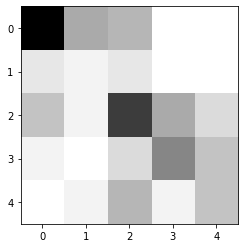

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds1) 
print("preds1 => Confusion Matrix")
print(cm)
plt.imshow(cm, cmap = 'binary')

In [ ]:
cm = confusion_matrix(labels, preds2) 
print("preds2(with TTA) => Confusion Matrix")
print(cm)
plt.imshow(cm, cmap = 'binary')

NameError: ignored

In [ ]:
# TTA is easy - use .TTA() in place of .get_preds()
# preds_tta, labels_tta = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
# acc_tta = accuracy(preds_tta, labels_tta)
# print(acc_tta)

In [ ]:
# test_images = []
# im_size = 224
# for image_path in df['path']:
#     img = cv2.imread(image_path)
#     img = cv2.resize(img, (im_size, im_size));
#     test_images.append(img);

In [ ]:
# test_pred = learn.predict_array(test_imgs)
# test_pred = np.argmax(test_pred, axis=1)
# test_pred

In [ ]:
# sample for finding quadratic weighted kappa
# from sklearn.metrics import cohen_kappa_score, confusion_matrix
# import numpy as np
# from time import time

# #dataset
# actuals = np.array([4, 4, 3, 4, 4, 0, 1, 1, 2, 1])
# preds   = np.array([0, 4, 1, 0, 4, 0, 1, 1, 2, 1])
# qwk = cohen_kappa_score(actuals, preds, weights="quadratic")
# print(qwk)

#Ensemble

In [29]:
learn_resnet = load_learner('/content/drive/MyDrive/IDRid/Models', 'ResNet.pkl')

In [30]:
learn_densenet = load_learner('/content/drive/MyDrive/IDRid/Models', 'DenseNet.pkl')

In [31]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=6ed4f1e0a91a297ba877569ca1ce23b8d1912e005bb502aae3ed96fec073a351
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [32]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3., reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = ((1 - pt)**self.gamma) * CE_loss
        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()

from efficientnet_pytorch import EfficientNet
learn_efficient = load_learner('/content/drive/MyDrive/IDRid/Models', 'EffNet_BenPreprocess_512.pkl')

In [33]:
learn_resnet.data.add_test(test)
learn_densenet.data.add_test(test)
learn_efficient.data.add_test(test_preprocessed)

In [34]:
# Get predictions
preds1, l1 = learn_resnet.get_preds(DatasetType.Test)
# preds2, l2 = learn_resnet.TTA(ds_type=DatasetType.Test)

preds_densenet, l3 = learn_densenet.get_preds(DatasetType.Test)
preds_efficient, l4 = learn_efficient.TTA(ds_type = DatasetType.Test)

In [35]:
preds1 = np.array(preds1)
# preds2 = np.array(preds2)
preds_densenet = np.array(preds_densenet)
preds_efficient = np.array(preds_efficient)
preds_ensenmble = preds1 + preds_densenet + preds_efficient
print("preds1", preds1.shape)
# print("preds2", preds2.shape)

preds1 (103, 5)


In [36]:
preds_ensemble_RD = preds1 + preds_densenet
preds_ensenmble_ED = preds_efficient + preds_densenet
preds_densenet_RE = preds1 + preds_efficient
print(preds_ensemble_RD.shape)

(103, 5)


In [37]:
preds1 = np.argmax(preds1, axis = 1)
# preds2 = np.argmax(preds2, axis = 1)
preds_densenet = np.argmax(preds_densenet, axis = 1)
preds_efficient = np.argmax(preds_efficient, axis = 1)
preds_ensenmble = np.argmax(preds_ensenmble, axis = 1)
print("preds1", preds1.shape)
# print("preds2", preds2.shape)

preds1 (103,)


In [38]:
labels = test_df['level']
labels.shape

(103,)

In [39]:
from sklearn.metrics import accuracy_score
print("preds1 => accuracy:", accuracy_score(labels, preds1))
# print("preds2(with TTA) => accuracy:", accuracy_score(labels, preds2))
print("preds_densenet => accuracy:", accuracy_score(labels, preds_densenet))
print("preds_efficient => accuracy:", accuracy_score(labels, preds_efficient))
print("preds_ensemble => accuracy:", accuracy_score(labels, preds_ensenmble))

preds1 => accuracy: 0.5145631067961165
preds_densenet => accuracy: 0.5339805825242718
preds_efficient => accuracy: 0.6699029126213593
preds_ensemble => accuracy: 0.6601941747572816


In [40]:
preds_ensemble_RD = np.argmax(preds_ensemble_RD, axis = 1)
preds_ensenmble_ED = np.argmax(preds_ensenmble_ED, axis = 1)
preds_densenet_RE = np.argmax(preds_densenet_RE, axis = 1)

In [41]:
print("preds_ensemble_RD => accuracy:", accuracy_score(labels, preds_ensemble_RD))
print("preds_ensenmble_ED => accuracy:", accuracy_score(labels, preds_ensenmble_ED))
print("preds_densenet_RE => accuracy:", accuracy_score(labels, preds_densenet_RE))

preds_ensemble_RD => accuracy: 0.5728155339805825
preds_ensenmble_ED => accuracy: 0.6893203883495146
preds_densenet_RE => accuracy: 0.6699029126213593


In [42]:
from sklearn.metrics import cohen_kappa_score
print("preds1 => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds1, weights = "quadratic"));
# print("preds2(with TTA) => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds2, weights = "quadratic"));
print("preds_densenet => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds_densenet, weights = "quadratic"));
print("preds_efficient => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds_efficient, weights = "quadratic"));
print("preds_ensemble => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds_ensenmble, weights = "quadratic"));

preds1 => quadratic_weighted_kappa: 0.6809734513274337
preds_densenet => quadratic_weighted_kappa: 0.5996358984451879
preds_efficient => quadratic_weighted_kappa: 0.7152816849727244
preds_ensemble => quadratic_weighted_kappa: 0.7189668165163838


In [43]:
print("preds_ensemble_RD => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds_ensemble_RD, weights = "quadratic"));
print("preds_ensenmble_ED => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds_ensenmble_ED, weights = "quadratic"));
print("preds_densenet_RE => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds_densenet_RE, weights = "quadratic"));

preds_ensemble_RD => quadratic_weighted_kappa: 0.6862011740519653
preds_ensenmble_ED => quadratic_weighted_kappa: 0.7107169253510717
preds_densenet_RE => quadratic_weighted_kappa: 0.7017552850736708
